In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = 'cuda:2'

In [14]:
attr_path  = {
    'zero': '/home/dhlee/results/cifar10/image_linear_zero_attribution.npy',
    'expected': '/home/dhlee/results/cifar10/image_linear_expected_attribution.npy',
    
    'latent_linear': '/home/dhlee/results/cifar10/latent_linear_attribution.npy',    
    'image_gradient_descent': '/home/dhlee/results/cifar10/image_gradient_descent_attribution.npy', # descent
    'image_gradient_ascent': '/home/dhlee/results/cifar10/image_gradient_ascent_attribution.npy',            
    'latent_gradient_descent': '/home/dhlee/results/cifar10/latent_gradient_descent_attribution.npy',
    'latent_gradient_ascent': '/home/dhlee/results/cifar10/latent_gradient_ascent_attribution.npy',
    
    'image_simple_gradient_descent': '/home/dhlee/results/cifar10/image_simple_gradient_descent_attribution.npy', # descent
    'image_simple_gradient_ascent': '/home/dhlee/results/cifar10/image_simple_gradient_ascent_attribution.npy',            
    'latent_simple_gradient_descent': '/home/dhlee/results/cifar10/latent_simple_gradient_descent_attribution.npy',
    'latent_simple_gradient_ascent': '/home/dhlee/results/cifar10/latent_simple_gradient_ascent_attribution.npy',
    
    'image_simple_fgsm': '/home/dhlee/results/cifar10/image_simple_fgsm_attribution.npy',
    'image_fgsm': '/home/dhlee/results/cifar10/image_fgsm_attribution.npy',
    'image_pgd': '/home/dhlee/results/cifar10/image_pgd_attribution.npy',
    'image_cw': '/home/dhlee/results/cifar10/image_cw_attribution.npy',

    'linear_latent_linear': '/home/dhlee/results/cifar10/latent_linear_interpolation_linear_attribution.npy',    
    'linear_image_gradient_descent': '/home/dhlee/results/cifar10/image_gradient_descent_interpolation_linear_attribution.npy', # descent
    'linear_image_gradient_ascent': '/home/dhlee/results/cifar10/image_gradient_ascent_interpolation_linear_attribution.npy',            
    'linear_latent_gradient_descent': '/home/dhlee/results/cifar10/latent_gradient_descent_interpolation_linear_attribution.npy',
    'linear_latent_gradient_ascent': '/home/dhlee/results/cifar10/latent_gradient_ascent_interpolation_linear_attribution.npy',
    
    'linear_image_simple_gradient_descent': '/home/dhlee/results/cifar10/image_simple_gradient_descent_interpolation_linear_attribution.npy', # descent
    'linear_image_simple_gradient_ascent': '/home/dhlee/results/cifar10/image_simple_gradient_ascent_interpolation_linear_attribution.npy',            
    'linear_latent_simple_gradient_descent': '/home/dhlee/results/cifar10/latent_simple_gradient_descent_interpolation_linear_attribution.npy',
    'linear_latent_simple_gradient_ascent': '/home/dhlee/results/cifar10/latent_simple_gradient_ascent_interpolation_linear_attribution.npy',
    
    'linear_image_simple_fgsm': '/home/dhlee/results/cifar10/image_simple_fgsm_interpolation_linear_attribution.npy',
    'linear_image_fgsm': '/home/dhlee/results/cifar10/image_fgsm_interpolation_linear_attribution.npy',
    'linear_image_pgd': '/home/dhlee/results/cifar10/image_pgd_interpolation_linear_attribution.npy',
    'linear_image_cw': '/home/dhlee/results/cifar10/image_cw_interpolation_linear_attribution.npy',
    
    '0': '/home/dhlee/results/cifar10/image_flat_0_linear_attribution.npy',
    '1': '/home/dhlee/results/cifar10/image_flat_1_linear_attribution.npy',
    '2': '/home/dhlee/results/cifar10/image_flat_2_linear_attribution.npy',
    '3': '/home/dhlee/results/cifar10/image_flat_3_linear_attribution.npy',
    '4': '/home/dhlee/results/cifar10/image_flat_4_linear_attribution.npy',
    '5': '/home/dhlee/results/cifar10/image_flat_5_linear_attribution.npy',
    '6': '/home/dhlee/results/cifar10/image_flat_6_linear_attribution.npy',
    '7': '/home/dhlee/results/cifar10/image_flat_7_linear_attribution.npy',
    '8': '/home/dhlee/results/cifar10/image_flat_8_linear_attribution.npy',
    '9': '/home/dhlee/results/cifar10/image_flat_9_linear_attribution.npy',
    '10': '/home/dhlee/results/cifar10/image_flat_10_linear_attribution.npy',
    '11': '/home/dhlee/results/cifar10/image_flat_11_linear_attribution.npy',
    '12': '/home/dhlee/results/cifar10/image_flat_12_linear_attribution.npy',
    '13': '/home/dhlee/results/cifar10/image_flat_13_linear_attribution.npy',
    '14': '/home/dhlee/results/cifar10/image_flat_14_linear_attribution.npy',
    '15': '/home/dhlee/results/cifar10/image_flat_15_linear_attribution.npy',
    '16': '/home/dhlee/results/cifar10/image_flat_16_linear_attribution.npy',
    '17': '/home/dhlee/results/cifar10/image_flat_17_linear_attribution.npy',
    '18': '/home/dhlee/results/cifar10/image_flat_18_linear_attribution.npy',
    '19': '/home/dhlee/results/cifar10/image_flat_19_linear_attribution.npy',
    '20': '/home/dhlee/results/cifar10/image_flat_20_linear_attribution.npy',
    '21': '/home/dhlee/results/cifar10/image_flat_21_linear_attribution.npy',
    '22': '/home/dhlee/results/cifar10/image_flat_22_linear_attribution.npy',
    '23': '/home/dhlee/results/cifar10/image_flat_23_linear_attribution.npy',
    '24': '/home/dhlee/results/cifar10/image_flat_24_linear_attribution.npy',    
    
}

interp_path  = {
    'zero': '/home/dhlee/results/cifar10/image_linear_zero_interpolation.npy',
    'expected': '/home/dhlee/results/cifar10/image_linear_expected_interpolation.npy',
    
    'latent_linear': '/home/dhlee/results/cifar10/latent_linear_interpolation.npy',    
    'image_gradient_descent': '/home/dhlee/results/cifar10/image_gradient_descent_interpolation.npy', # descent
    'image_gradient_ascent': '/home/dhlee/results/cifar10/image_gradient_ascent_interpolation.npy',            
    'latent_gradient_descent': '/home/dhlee/results/cifar10/latent_gradient_descent_interpolation.npy',
    'latent_gradient_ascent': '/home/dhlee/results/cifar10/latent_gradient_ascent_interpolation.npy',
    
    'image_simple_gradient_descent': '/home/dhlee/results/cifar10/image_simple_gradient_descent_interpolation.npy', # descent
    'image_simple_gradient_ascent': '/home/dhlee/results/cifar10/image_simple_gradient_ascent_interpolation.npy',            
    'latent_simple_gradient_descent': '/home/dhlee/results/cifar10/latent_simple_gradient_descent_interpolation.npy',
    'latent_simple_gradient_ascent': '/home/dhlee/results/cifar10/latent_simple_gradient_ascent_interpolation.npy',
    
    'image_simple_fgsm': '/home/dhlee/results/cifar10/image_simple_fgsm_interpolation.npy',
    'image_fgsm': '/home/dhlee/results/cifar10/image_fgsm_interpolation.npy',
    'image_pgd': '/home/dhlee/results/cifar10/image_pgd_interpolation.npy',
    'image_cw': '/home/dhlee/results/cifar10/image_cw_interpolation.npy',

    'linear_latent_linear': '/home/dhlee/results/cifar10/latent_linear_interpolation_linear_interpolation.npy',    
    'linear_image_gradient_descent': '/home/dhlee/results/cifar10/image_gradient_descent_interpolation_linear_interpolation.npy', # descent
    'linear_image_gradient_ascent': '/home/dhlee/results/cifar10/image_gradient_ascent_interpolation_linear_interpolation.npy',            
    'linear_latent_gradient_descent': '/home/dhlee/results/cifar10/latent_gradient_descent_interpolation_linear_interpolation.npy',
    'linear_latent_gradient_ascent': '/home/dhlee/results/cifar10/latent_gradient_ascent_interpolation_linear_interpolation.npy',
    
    'linear_image_simple_gradient_descent': '/home/dhlee/results/cifar10/image_simple_gradient_descent_interpolation_linear_interpolation.npy', # descent
    'linear_image_simple_gradient_ascent': '/home/dhlee/results/cifar10/image_simple_gradient_ascent_interpolation_linear_interpolation.npy',            
    'linear_latent_simple_gradient_descent': '/home/dhlee/results/cifar10/latent_simple_gradient_descent_interpolation_linear_interpolation.npy',
    'linear_latent_simple_gradient_ascent': '/home/dhlee/results/cifar10/latent_simple_gradient_ascent_interpolation_linear_interpolation.npy',
    
    'linear_image_simple_fgsm': '/home/dhlee/results/cifar10/image_simple_fgsm_interpolation_linear_interpolation.npy',
    'linear_image_fgsm': '/home/dhlee/results/cifar10/image_fgsm_interpolation_linear_interpolation.npy',
    'linear_image_pgd': '/home/dhlee/results/cifar10/image_pgd_interpolation_linear_interpolation.npy',
    'linear_image_cw': '/home/dhlee/results/cifar10/image_cw_interpolation_linear_interpolation.npy',
    
    '0': '/home/dhlee/results/cifar10/image_flat_0_linear_interpolation.npy',
    '1': '/home/dhlee/results/cifar10/image_flat_1_linear_interpolation.npy',
    '2': '/home/dhlee/results/cifar10/image_flat_2_linear_interpolation.npy',
    '3': '/home/dhlee/results/cifar10/image_flat_3_linear_interpolation.npy',
    '4': '/home/dhlee/results/cifar10/image_flat_4_linear_interpolation.npy',
    '5': '/home/dhlee/results/cifar10/image_flat_5_linear_interpolation.npy',
    '6': '/home/dhlee/results/cifar10/image_flat_6_linear_interpolation.npy',
    '7': '/home/dhlee/results/cifar10/image_flat_7_linear_interpolation.npy',
    '8': '/home/dhlee/results/cifar10/image_flat_8_linear_interpolation.npy',
    '9': '/home/dhlee/results/cifar10/image_flat_9_linear_interpolation.npy',
    '10': '/home/dhlee/results/cifar10/image_flat_10_linear_interpolation.npy',
    '11': '/home/dhlee/results/cifar10/image_flat_11_linear_interpolation.npy',
    '12': '/home/dhlee/results/cifar10/image_flat_12_linear_interpolation.npy',
    '13': '/home/dhlee/results/cifar10/image_flat_13_linear_interpolation.npy',
    '14': '/home/dhlee/results/cifar10/image_flat_14_linear_interpolation.npy',
    '15': '/home/dhlee/results/cifar10/image_flat_15_linear_interpolation.npy',
    '16': '/home/dhlee/results/cifar10/image_flat_16_linear_interpolation.npy',
    '17': '/home/dhlee/results/cifar10/image_flat_17_linear_interpolation.npy',
    '18': '/home/dhlee/results/cifar10/image_flat_18_linear_interpolation.npy',
    '19': '/home/dhlee/results/cifar10/image_flat_19_linear_interpolation.npy',
    '20': '/home/dhlee/results/cifar10/image_flat_20_linear_interpolation.npy',
    '21': '/home/dhlee/results/cifar10/image_flat_21_linear_interpolation.npy',
    '22': '/home/dhlee/results/cifar10/image_flat_22_linear_interpolation.npy',
    '23': '/home/dhlee/results/cifar10/image_flat_23_linear_interpolation.npy',
    '24': '/home/dhlee/results/cifar10/image_flat_24_linear_interpolation.npy',    
    
}

load attribution, interpolation

In [2]:
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked/', train=False, transform=transform)


In [3]:
def make_key(keys, method, ratio):
    ans = []
    for i in keys:
        if method in i:
            if ratio in i:
                ans.append(i)
    return i
                

Show metric

In [4]:
import json

with open("/home/dhlee/code/ig_inversion/results/evaluation_average_cifar10.json", "r") as st_json:
    avg = json.load(st_json)

with open("/home/dhlee/code/ig_inversion/results/evaluation_samples_cifar10.json", "r") as all_json:
    all = json.load(all_json)


['morf_0_0.2', 'morf_14_0.2', 'morf_15_0.2', 'morf_1_0.2', 'morf_20_0.2', 'morf_21_0.2', 'morf_7_0.2', 'morf_8_0.2', 'morf_expected_0.2', 'morf_image_cw_0.2', 'morf_image_fgsm_0.2', 'morf_image_gradient_ascent_0.2', 'morf_image_gradient_descent_0.2', 'morf_image_pgd_0.2', 'morf_image_simple_fgsm_0.2', 'morf_image_simple_gradient_ascent_0.2', 'morf_image_simple_gradient_descent_0.2', 'morf_latent_gradient_ascent_0.2', 'morf_latent_gradient_descent_0.2', 'morf_latent_linear_0.2', 'morf_latent_simple_gradient_ascent_0.2', 'morf_latent_simple_gradient_descent_0.2', 'morf_linear_image_cw_0.2', 'morf_linear_image_fgsm_0.2', 'morf_linear_image_gradient_ascent_0.2', 'morf_linear_image_gradient_descent_0.2', 'morf_linear_image_pgd_0.2', 'morf_linear_image_simple_fgsm_0.2', 'morf_linear_image_simple_gradient_ascent_0.2', 'morf_linear_image_simple_gradient_descent_0.2', 'morf_linear_latent_gradient_ascent_0.2', 'morf_linear_latent_gradient_descent_0.2', 'morf_linear_latent_linear_0.2', 'morf_line

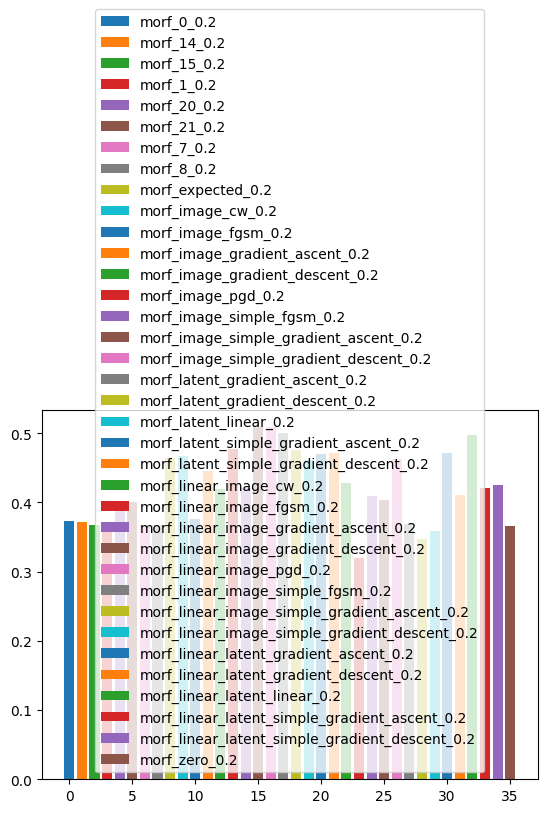

In [5]:
method = "morf"
ratio = "0.2"

check_key = []
for i in list(avg.keys()):
    if ratio in i:
        if method in i:
            # print(i)
            check_key.append(i)

print(check_key)

result = []
for i in check_key:
    result.append(avg[f'{i}'])

print(result)
                
for i in range(len(check_key)):
    plt.bar(i, result[i], label = f'{check_key[i]}')
    plt.legend(loc = 8)
    # plt.bar(check_key, result)


In [22]:
pr = 'aopc_image_gradient_0.01'
re = "".join(reversed(pr))
print(pr.find('_'))
print(re.find('_'))
print(len(pr)- re.find('_'))
print(pr[4], pr[20 - 1])
print(pr[4+1:20-1])

4
4
20
_ _
image_gradient


class specific score

In [6]:
check_key

['morf_expected_0.2',
 'morf_image_fgsm_0.2',
 'morf_image_gradient_ascent_0.2',
 'morf_image_gradient_descent_0.2',
 'morf_image_pgd_0.2',
 'morf_image_simple_fgsm_0.2',
 'morf_image_simple_gradient_ascent_0.2',
 'morf_image_simple_gradient_descent_0.2',
 'morf_latent_gradient_ascent_0.2',
 'morf_latent_gradient_descent_0.2',
 'morf_latent_linear_0.2',
 'morf_latent_simple_gradient_ascent_0.2',
 'morf_latent_simple_gradient_descent_0.2',
 'morf_linear_image_fgsm_0.2',
 'morf_linear_image_gradient_ascent_0.2',
 'morf_linear_image_gradient_descent_0.2',
 'morf_linear_image_pgd_0.2',
 'morf_linear_image_simple_fgsm_0.2',
 'morf_linear_image_simple_gradient_ascent_0.2',
 'morf_linear_image_simple_gradient_descent_0.2',
 'morf_linear_latent_gradient_ascent_0.2',
 'morf_linear_latent_gradient_descent_0.2',
 'morf_linear_latent_linear_0.2',
 'morf_linear_latent_simple_gradient_ascent_0.2',
 'morf_linear_latent_simple_gradient_descent_0.2',
 'morf_zero_0.2']

In [25]:
wrong = []
for i in check_key:
    temp = all[i]
    
    idx = []
    for j in range(len(temp)):
        if temp[j]: pass
        else: idx.append(j)
    wrong.append(idx)

In [30]:
score = {}
for i in range(10):
    j = str(i)
    score[j] = 0
score

{'0': 0,
 '1': 0,
 '2': 0,
 '3': 0,
 '4': 0,
 '5': 0,
 '6': 0,
 '7': 0,
 '8': 0,
 '9': 0}

In [35]:
import copy

all_score = []

for i in range(len(wrong)):
    one_score = copy.deepcopy(score)
    wr = wrong[i]
    
    for j in range(len(wr)):
        idx = wr[j]
        lab = valid_dataset[idx][1]
        
        one_score[f'{lab}'] = one_score[f'{lab}'] + 1
    all_score.append(one_score)
    
    # break
        

In [36]:
for i in range(len(all_score)):
    print(check_key[i])
    print(all_score[i])
# one_score
# score

morf_expected_0.2
{'0': 428, '1': 584, '2': 566, '3': 655, '4': 465, '5': 916, '6': 73, '7': 703, '8': 556, '9': 419}
morf_image_fgsm_0.2
{'0': 641, '1': 722, '2': 587, '3': 642, '4': 580, '5': 906, '6': 63, '7': 824, '8': 654, '9': 622}
morf_image_gradient_ascent_0.2
{'0': 531, '1': 532, '2': 548, '3': 578, '4': 512, '5': 938, '6': 58, '7': 774, '8': 543, '9': 534}
morf_image_gradient_descent_0.2
{'0': 527, '1': 690, '2': 572, '3': 635, '4': 550, '5': 931, '6': 68, '7': 764, '8': 587, '9': 476}
morf_image_pgd_0.2
{'0': 327, '1': 540, '2': 596, '3': 650, '4': 468, '5': 901, '6': 107, '7': 709, '8': 532, '9': 400}
morf_image_simple_fgsm_0.2
{'0': 500, '1': 671, '2': 613, '3': 615, '4': 563, '5': 885, '6': 70, '7': 760, '8': 606, '9': 510}
morf_image_simple_gradient_ascent_0.2
{'0': 24, '1': 418, '2': 455, '3': 588, '4': 698, '5': 626, '6': 699, '7': 649, '8': 389, '9': 368}
morf_image_simple_gradient_descent_0.2
{'0': 24, '1': 418, '2': 455, '3': 588, '4': 698, '5': 626, '6': 699, '7': 

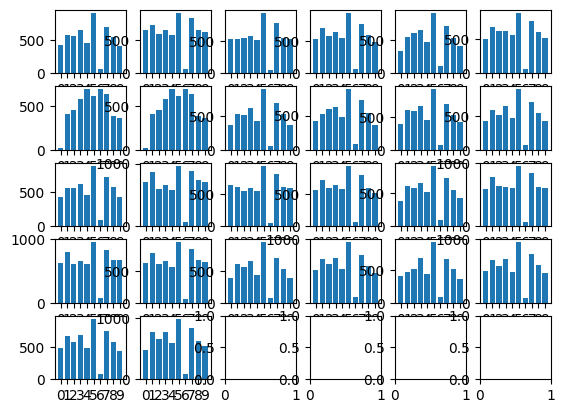

In [59]:
fig, axes = plt.subplots(5, 6)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))
for i in range(len(check_key)):
    ax = next(axes_flat)
    # ax.imshow(convert_to_img(x))

    # plt.plot(one_score)
    # print(i)
    ax.bar(*zip(*sorted(all_score[i].items())))
    # print(all_score[i])


In [85]:
print(check_key[6])
print(check_key[7])

morf_image_simple_gradient_ascent_0.2
morf_image_simple_gradient_descent_0.2


In [86]:
for i in range(20):
    lab = valid_dataset[i][1]
    if lab == 0:
        print(i)

3
10


In [87]:
convert_to_img(valid_dataset[3][0]).shape

(32, 32, 3)

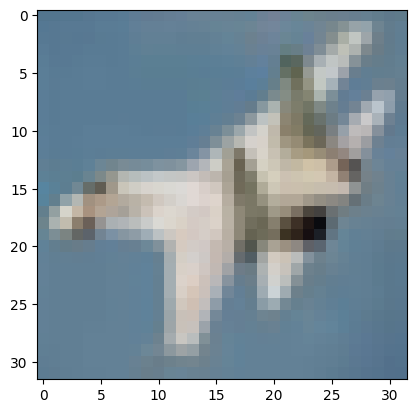

In [89]:
from ig_pkg.misc import convert_to_img
plt.imshow(convert_to_img(valid_dataset[10][0]))

indexing

In [6]:
index = {}
for i in range(10):
    j = str(i)
    index[j] = []
index

{'0': [],
 '1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': []}

In [7]:
for i in range(len(valid_dataset)):
    lab = valid_dataset[i][1]
    # print(lab)
    # print(index[f'{lab}'])
    temp = index[f'{lab}']
    temp.append(i)
    index[f'{lab}'] = temp

In [9]:
with open(os.path.join('/home/dhlee/code/ig_inversion/results/json', f"class_index_cifar10.json"), 'w') as f:
    json.dump(index, f, indent=2, sort_keys=True)            

In [92]:
di = {}
for i in range(len(check_key)):
    di[f'{check_key[i]}'] = all_score[i]
di

{'morf_expected_0.2': {'0': 428,
  '1': 584,
  '2': 566,
  '3': 655,
  '4': 465,
  '5': 916,
  '6': 73,
  '7': 703,
  '8': 556,
  '9': 419},
 'morf_image_fgsm_0.2': {'0': 641,
  '1': 722,
  '2': 587,
  '3': 642,
  '4': 580,
  '5': 906,
  '6': 63,
  '7': 824,
  '8': 654,
  '9': 622},
 'morf_image_gradient_ascent_0.2': {'0': 531,
  '1': 532,
  '2': 548,
  '3': 578,
  '4': 512,
  '5': 938,
  '6': 58,
  '7': 774,
  '8': 543,
  '9': 534},
 'morf_image_gradient_descent_0.2': {'0': 527,
  '1': 690,
  '2': 572,
  '3': 635,
  '4': 550,
  '5': 931,
  '6': 68,
  '7': 764,
  '8': 587,
  '9': 476},
 'morf_image_pgd_0.2': {'0': 327,
  '1': 540,
  '2': 596,
  '3': 650,
  '4': 468,
  '5': 901,
  '6': 107,
  '7': 709,
  '8': 532,
  '9': 400},
 'morf_image_simple_fgsm_0.2': {'0': 500,
  '1': 671,
  '2': 613,
  '3': 615,
  '4': 563,
  '5': 885,
  '6': 70,
  '7': 760,
  '8': 606,
  '9': 510},
 'morf_image_simple_gradient_ascent_0.2': {'0': 24,
  '1': 418,
  '2': 455,
  '3': 588,
  '4': 698,
  '5': 626,
  

In [94]:
with open(os.path.join('/home/dhlee/code/ig_inversion/results/json', f"morf_class_score_cifar10.json"), 'w') as f:
    json.dump(di, f, indent=2, sort_keys=True)            

In [ ]:
index = {}
for i in range(10):
    j = str(i)
    index[j] = []
index

{'0': [],
 '1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': []}

In [ ]:
index = {}
for i in range(10):
    j = str(i)
    index[j] = []
index

{'0': [],
 '1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': []}

show interpolation

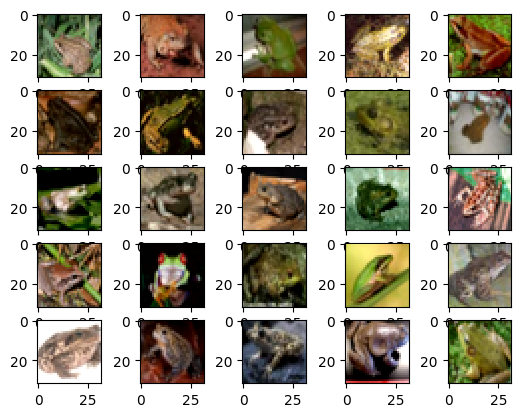

In [12]:
fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat

temp = index['6']
for i in range(25):
    ax=next(axes_flat)
    ax.imshow(convert_to_img(valid_dataset[temp[i]][0]))
    

In [19]:
temp[0]
interp[temp[0]].shape

torch.Size([25, 3, 32, 32])

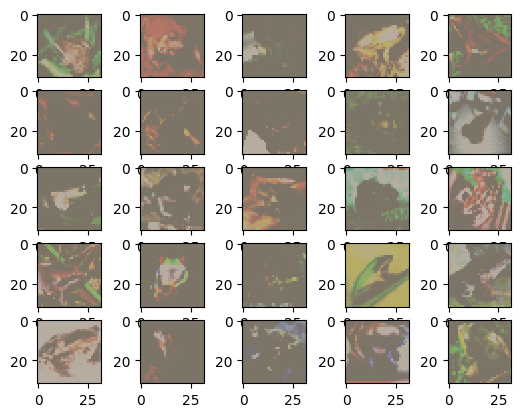

In [21]:
fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat

temp = index['6']
path = interp_path['image_pgd']
# interp = torch.from_numpy(np.load(path))
for i in range(25):
    ax=next(axes_flat)
    ax.imshow(convert_to_img(interp[temp[i]][-1]))
    

In [ ]:

'0': 0,
'1': 0,
'2': 0,
'3': 0,
'4': 0,
'5': 0,
'6': 0,
'7': 0,
'8': 0,
'9': 0,
'10': 0,
'11': 0,
'12': 0,
'13': 0,
'14': 0,
'15': 
'16':
'17':
'18':
'19':
'20':
'21':
'22':
'23':
'24':

In [23]:
# tm = interp[:, -1, :, :]
# print(tm.shape)

path = interp_path['image_fgsm']
interp = np.load(path)
print(interp.shape)
inte = interp[:, -1, :, -1]
print(inte.shape)


(10000, 25, 3, 32, 32)
(10000, 3, 32)


merging result

In [96]:
old = json.load(open('/home/dhlee/code/ig_inversion/results/evaluation_average_cifar10.json'))
new = json.load(open('/home/dhlee/code/ig_inversion/results/temp/evaluation_average_cifar10.json'))

In [102]:
# real = old.update(new)
# real.keys()
# print(sorted(old.keys()))
with open(os.path.join('/home/dhlee/code/ig_inversion/results/', f"evaluation_average_cifar10.json"), 'w') as f:
    json.dump(old, f, indent=2, sort_keys=True)            

In [103]:
old = json.load(open('/home/dhlee/code/ig_inversion/results/temp/evaluation_samples_cifar10_old.json'))
new = json.load(open('/home/dhlee/code/ig_inversion/results/temp/evaluation_samples_cifar10_temp.json'))

old.update(new)
with open(os.path.join('/home/dhlee/code/ig_inversion/results/', f"evaluation_samples_cifar10.json"), 'w') as f:
    json.dump(old, f, indent=2, sort_keys=True)   

download MNIST 

In [24]:
from torchvision import datasets

root = '/data8/donghun/'
train_data = datasets.MNIST(root = root,
                            train=True,
                            download=True,
                            transform=T.ToTensor())
test_data = datasets.MNIST(root = root,
                            train=False,
                            download=True,
                            transform=T.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data8/donghun/MNIST/raw/train-images-idx3-ubyte.gz to /data8/donghun/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data8/donghun/MNIST/raw/train-labels-idx1-ubyte.gz to /data8/donghun/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data8/donghun/MNIST/raw/t10k-images-idx3-ubyte.gz to /data8/donghun/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data8/donghun/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data8/donghun/MNIST/raw

number of training data :  60000
number of test data :  10000


In [30]:
MNIST_MEAN = [0.1307]
MNIST_STD  = [0.3081] 

train_data = datasets.MNIST(root = root,
                            train=True,
                            # download=True,
                            transform=T.Compose([T.ToTensor(), T.Normalize(mean = MNIST_MEAN, std = MNIST_STD)]),
)

In [41]:
import torch 
from ebm_pkg.models import get_model
from ebm_pkg.datasets import get_datasets
from ebm_pkg.ebm.sampler import Sampler
import numpy as np 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
from ebm_pkg.datasets import CIFAR10_MEAN, CIFAR10_STD, MNIST_MEAN, MNIST_STD

from ebm_pkg.loss import compute_entropy
import seaborn as sns 

path = f"/home/dhlee/code/paper_code_exercise/prev___ebm_classification/results/train/mnist/baseline/seed_0"

configs = {
    "cnn" : (10, 'relu' , 256, None), 
    # "resnet18" : (flags.num_classes, 'relu', flags.cnn_dim, flags.avg_pool_size)
}
out_features, activation, cnn_dim, last_avg_kernel_size = configs['cnn']
model = get_model('cnn', 
                in_channels=1,
                out_features=out_features,
                activation=activation,
                cnn_dim=cnn_dim,
                dropout_p = 0.5,
                last_avg_kernel_size=last_avg_kernel_size)
model.load_state_dict(torch.load(f"{path}/model_best.pt"))

# num_classes: 10
# batch_size: 128
# cnn_dim: 256
# avg_pool_size: 3
# in_channels: 1
# epoch_num: 25
# save_epochs: 20
# learning_rate: 0.0003
# learning_rate_decay: 1.0
# lagevian_steps: 20
# lagevian_step_size: 10.0
# binomial: 0.25
# dropout_p: 0.5
# ce_coeff: 1.0
# pos_ent_coeff: 1.0
# neg_ent_coeff: 1.0
# data: mnist
# model: cnn


cnn


<All keys matched successfully>

In [49]:
from tqdm import tqdm
device='cuda:5'
# classifier = torch.load('/data8/donghun/cifar10/results/densenet/script_model.pt', map_location='cpu').eval().to(device)
# classifier = mo.eval().to(device)
classifier = model.eval().to(device)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=2)

sc = 0
for i, j in enumerate(tqdm(valid_dataloader)):
    input, labe = j
    labe = labe.to(device)
    input = input.to(device)
    hat = torch.argmax(classifier(input), dim=-1)
    # print(hat)
    
    c = (hat==labe).sum().item()
    # print(c)
    sc += c
    # break
    

100%|██████████| 3750/3750 [00:10<00:00, 351.27it/s]


In [51]:
# sc /60000
# 

0.9787333333333333

In [60]:
from ig_pkg.utils.eval import Cifar10Evaluator
from ig_pkg.utils.metrics import * #morf, lerf, 
from ig_pkg.utils.attribution import *
import torchvision.transforms as T

MNIST_MEAN = [0.1307]
MNIST_STD  = [0.3081] 

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(MNIST_MEAN, MNIST_STD)
            ])

train_data = torchvision.datasets.MNIST(root = root,
                            train=True,
                            transform=T.Compose([T.ToTensor(), T.Normalize(mean = MNIST_MEAN, std = MNIST_STD)]),
)
# classifier = torch.load(args.model_path, map_location='cpu')

# baseline = torch.load('/root/tensor.pt', map_location='cpu')
baseline = torch.load('/data8/donghun/cifar10/tensor.pt', map_location='cpu')
temp = baseline[0][0]
temp = T.Resize(28)(temp.unsqueeze(0))
# baseline = baseline[args.type].to(args.device)

pbar = tqdm(range(len(train_data)))
pbar.set_description(f" Generating [👾] | generating attribution | ")

model = classifier.eval().to(device)

interpolation = []
attribution = []

for idx in pbar:
    
    baseline = temp.clone().detach().to(device)
    
    input, label = train_data[idx]
    input = input.to(device)
    interp = linear_interpolation(input, 24, baseline).to(device) # tensor
    attrib = integrated_gradient(model, input, label, baseline, interp, device) # tensor
    
    interpolation.append(interp.detach().cpu())
    attribution.append(attrib.detach().cpu())

interpolation = torch.stack(interpolation)
attribution = torch.stack(attribution)


 Generating [👾] | generating attribution | : 100%|██████████| 60000/60000 [05:58<00:00, 167.37it/s]


In [61]:
np.save(f'/home/dhlee/results/mnist/linear_0_interpolation.npy', interpolation.numpy())
np.save(f'/home/dhlee/results/mnist/linear_0_attribution.npy', attribution.numpy())